In [1]:
import numpy as np
import matplotlib.pyplot as plt

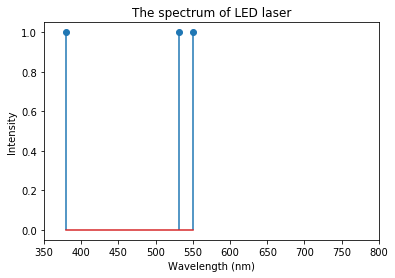

In [2]:
# lam_x = np.array([0.380, 0.532, 0.780])
lam_x = np.array([0.380, 0.532, 0.550])
inten_x = np.array([1, 1, 1])

max_index = 1
lam_depth = len(lam_x)

plt.stem(lam_x*1.0e3, inten_x, use_line_collection=True)
plt.xlim(350,800)
plt.title('The spectrum of LED laser')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

In [3]:
%matplotlib inline

logo = plt.imread('EK_1616x1616.png')[:,:,0]
ll, mm = 1616, 2048

logo = (logo>0.5)*1

logo = np.hstack((np.zeros((ll,(mm-ll)//2)),logo,np.zeros((ll,(mm-ll)//2))))
logo = np.vstack((np.zeros(((mm-ll)//2,mm)),logo,np.zeros(((mm-ll)//2,mm))))

# logo = logo[::16,::16]
# logo = np.kron(logo, np.ones((8,8)))
logo = logo.astype(np.int8)

p = logo.shape[0]                # pxp target image

target_coords = np.where( logo > 0 )

target = logo
print("Target image size: ",p,"x",p,'\n')

lam = lam_x[max_index]

m = p*p                          # number of pixels in target image

q   = int(1.0*p)
d   = 2.0                        # pitch: 2 micrometer
f   = p/lam*4

# list of SLM pixels contained in the pupil
slm_x, slm_y = np.meshgrid( np.arange(q), np.arange(q) )
slm_x = ( slm_x - int(q/2) ) * d
slm_y = ( slm_y - int(q/2) ) * d
slm_x = slm_x.astype(np.float32)
slm_y = slm_y.astype(np.float32)

# quad_phase = np.zeros((q,q,), dtype=np.complex64)
# quad_phase = np.exp(1j*np.pi/(lam*f)*( slm_x**2 + slm_y**2 ))

pup_ind = np.kron(range(q),np.ones(q,dtype=np.int8)), \
          np.kron(np.ones(q,dtype=np.int8),range(q))

n = pup_ind[0].shape[0]

SLM_size = int(d*q)              # in um
IMG_size = int(lam_x[-1]*f/d)    # in um
IMG_pitch = IMG_size/p           # in um


#px = ( px_ind - int(p/2) ) * IMG_pitch
#py = ( py_ind - int(p/2) ) * IMG_pitch
#pz = ( py_ind*0 + f )

print("The number of SLM pixels: ",n)
print("The number of IMG pixels: ",m)
print("Focal length: ",f*1e-3,"(mm)")
print("SLM pitch:",d,"(um)")
print("IMG pitch:", IMG_pitch,"(um)")
print("SLM size: ", SLM_size, "x", SLM_size, "(um)")
print("IMG size: ", IMG_size, "x", IMG_size, "(um)")
print("Fresnel number: ", SLM_size**2/4/lam/f)

Target image size:  2048 x 2048 

The number of SLM pixels:  4194304
The number of IMG pixels:  4194304
Focal length:  15.398496240601505 (mm)
SLM pitch: 2.0 (um)
IMG pitch: 2.0673828125 (um)
SLM size:  4096 x 4096 (um)
IMG size:  4234 x 4234 (um)
Fresnel number:  512.0


In [4]:
quad_phase_3d = np.zeros((q,q,lam_depth), dtype=np.complex64)
for i in range(lam_depth):
    quad_phase_3d[:,:,i] = np.exp(1j*np.pi/(lam_x[i]*f)*( slm_x**2 + slm_y**2 ))
    
print('lam_depth :',lam_depth)

lam_depth : 3


In [5]:
# filename = 'data_jhk_IMG16384x16384_SLM16384x16384_nlevels64.csv'
filename = 'data_jhk_IMG2048x2048_SLM2048x2048_nlevels64.csv'
n_levels = 64
phase_disc = np.loadtxt(filename)
phase_disc *= n_levels/256

phase_ls = phase_disc/n_levels*2*np.pi

d_n = 0.6                        # Refractive index of Photoresist : 1.6
LC_d_ls = phase_ls * lam/(2*np.pi*d_n)

In [6]:
intensity_ls = np.zeros((p,p,lam_depth), dtype=np.float32)

for i in range(lam_depth):
    phase_temp = LC_d_ls*2*np.pi*d_n/lam_x[i]
    xxx = np.exp(1j*phase_temp)*quad_phase_3d[:,:,i]
    zzz = inten_x[i]*np.exp(1j*2*np.pi*f/lam_x[i])/(1j*lam_x[i]*f)*np.fft.fft2(xxx)/n
    intensity_ls[:,:,i] += np.abs(zzz)**2
del xxx, zzz

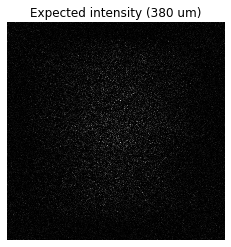

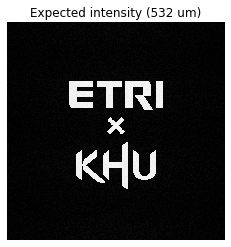

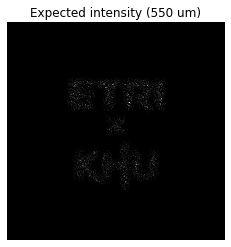

In [7]:
# 여러 파장에 대한 실험 결과

for i in range(lam_depth):
    plt.imshow(intensity_ls[:,:,i], cmap='gray')
    plt.axis('off')
    plt.title('Expected intensity (%d um)' %(lam_x[i]*1000))
    plt.show()

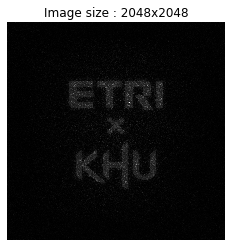

In [8]:
img_intensity = np.zeros((p,p), dtype=np.float32)

for i in range(lam_depth):
    img_intensity += intensity_ls[:,:,i]
    
plt.imshow(img_intensity, cmap='gray')
plt.axis('off')
plt.title('Image size : %dx%d' %(p,p))
plt.show()